In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import glob
from scipy.stats import ks_2samp, kstest
%matplotlib inline

In [2]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [3]:
def load_experiment(input_path="../data/mstar_selected_summary/vmax_sorted/", fixed_number=False, full_data=False):
    files = glob.glob(input_path+"M31_group_*")
    group_id = []
    for f in files:
        i = int(f.split("_")[-5])
        if i not in group_id:
            group_id.append(i)
    print(group_id, len(group_id))

    n_groups = len(group_id)

    if fixed_number:
        n_iter = np.arange(5)
    else:
        n_iter = np.arange(11,16)
    
    fields = ['width','mu', 'a', 'ba_ratio', 'ca_ratio']
    M31_all = {}
    MW_all = {}
    if not full_data:
        for field in fields:
            M31_all[field] = np.ones(n_groups)
            MW_all[field] = np.ones(n_groups)
            M31_all[field+'_sigma'] = np.ones(n_groups)
            MW_all[field+'_sigma'] = np.ones(n_groups)
        
            M31_all[field+'_random'] = np.ones(n_groups)
            MW_all[field+'_random'] = np.ones(n_groups)
            M31_all[field+'_random_sigma'] = np.ones(n_groups)
            MW_all[field+'_random_sigma'] = np.ones(n_groups)
    else:
        for field in fields:
            M31_all[field] = np.empty((0))
            MW_all[field] = np.empty((0))
            M31_all[field+'_random'] = np.empty((0))
            MW_all[field+'_random'] = np.empty((0))
           

    for g in range(n_groups):

        MW_summary = {}
        M31_summary = {}
    
        for i in n_iter:
            if fixed_number:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], 11, i))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g],11, i))
            else:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))

            MW_summary[i] = load_summary(filename_MW)
            M31_summary[i] = load_summary(filename_M31)
    
        
        for field in fields:
            a = np.empty((0))
            b = np.empty((0))
            a_random = np.empty((0))
            b_random = np.empty((0))
        
            for i in n_iter:
                data = M31_summary[i]
                a = np.append(a, data[field][0])
                a_random = np.append(a_random, data[field][1:101])
        
                data = MW_summary[i]
                b = np.append(b, data[field][0])
                b_random = np.append(b_random, data[field][1:101])
                #print('a_random {} iter: {} {}'.format(field, i, a_random))
                
            if not full_data:
                M31_all[field][g] = np.average(a)
                MW_all[field][g] = np.average(b)
                M31_all[field+'_sigma'][g] = np.std(a)
                MW_all[field+'_sigma'][g] = np.std(b)
                M31_all[field+'_random'][g] = np.average(a_random)
                MW_all[field+'_random'][g] = np.average(b_random)
                M31_all[field+'_random_sigma'][g] = np.std(a_random)
                MW_all[field+'_random_sigma'][g] = np.std(b_random)
            else:
                M31_all[field] = np.append(M31_all[field], a)
                MW_all[field] = np.append(MW_all[field], b)
                M31_all[field+'_random'] = np.append(M31_all[field+'_random'], a_random)
                MW_all[field+'_random'] = np.append(MW_all[field+'_random'], b_random)
                
    return M31_all, MW_all

In [4]:
in_path = "../data/mstar_selected_summary/vmax_random/"
M31_sim_vmax_random, MW_sim_vmax_random= load_experiment(input_path=in_path, fixed_number=True)
in_path = "../data/mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted, MW_sim_vmax_sorted = load_experiment(input_path=in_path, fixed_number=False)


[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20
[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20


In [9]:
fields = ['width', 'ca_ratio', 'ba_ratio']
n_fields = len(fields)
data = np.zeros((2*n_fields, len(M31_sim_vmax_sorted['width'])))
for i in range(n_fields):
    field = fields[i]
    x_sim = (M31_sim_vmax_sorted[field] - M31_sim_vmax_sorted[field+'_random'])/M31_sim_vmax_sorted[field+'_random_sigma']
    y_sim = (MW_sim_vmax_sorted[field] - MW_sim_vmax_sorted[field+'_random'])/MW_sim_vmax_sorted[field+'_random_sigma']
    data[i,:] = x_sim[:]
    data[i+3,:] = y_sim[:]


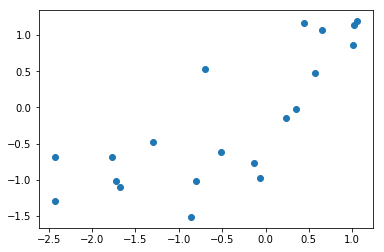

In [29]:
plt.scatter(data[1,:], data[0,:])

[[ 0.84710038  0.81319084  0.45958484]
 [ 0.81319084  1.3039204  -0.18562078]
 [ 0.45958484 -0.18562078  1.04347181]]
[[ 0.77677966  0.67032829  0.44452414]
 [ 0.67032829  0.84497426  0.05896295]
 [ 0.44452414  0.05896295  0.67399735]]


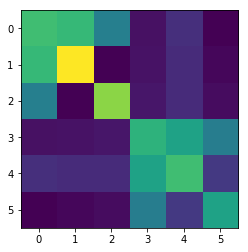

In [21]:
data_cov = np.cov(data)
data_mean = np.zeros(2*n_fields)
plt.imshow(data_cov.T)
print(data_cov[0:3, 0:3])
print(data_cov[3:6, 3:6])

In [42]:
data_random = np.random.multivariate_normal(data_mean, data_cov, size=10000)

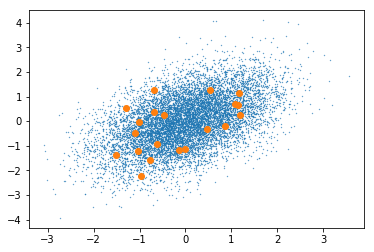

In [47]:
plt.scatter(data_random[:,0], data_random[:,2], s=0.1)
plt.scatter(data[0,:], data[2,:])
plt.subplot
plt.scatter(data_random[:,0], data_random[:,2], s=0.1)
plt.scatter(data[0,:], data[2,:])

In [51]:
data_r_abs = np.abs(data_random)
in_peak = (data_r_abs[:,0]< 2) & (data_r_abs[:,1]<2) & (data_r_abs[:,2]<2) &\
         (data_r_abs[:,3]< 2) & (data_r_abs[:,4]<2) & (data_r_abs[:,5]<2)
print(np.count_nonzero(in_peak))
out_peak = (data_r_abs[:,0]< 2) & (data_r_abs[:,1]<2) & (data_r_abs[:,2]<2) &\
         (data_r_abs[:,3]> 2) & (data_r_abs[:,4]>2) & (data_r_abs[:,5]<2)
n_in=np.count_nonzero(in_peak)
n_out=np.count_nonzero(out_peak)
print(n_in, n_out, n_out/n_in, n_in/n_out)

8275
8275 99 0.011963746223564956 83.58585858585859
